In [1]:
import os, pdb

import matplotlib.pyplot as plt

import pandas as pd

import statsmodels.api as sm

In [5]:
ROOT = '../run_methods_example/gray_box/result_csvs'
ROOT_RC = '../run_methods_example/gray_box/rc_results'

In [6]:
epws   = ['victoria.epw', 'chicago.epw']                      # weather
idfs   = ['control_concrete.idf', 'control_wood.idf',         # envelope
          'control_concrete_inf.idf', 'control_wood_inf.idf'] # infiltration
scheds = [False, True]                                        # schedules

In [45]:
# NOTE - SOME CASES DID NOT RUN FOR SOME REASON.. NEED TO LOOK INTO THIS BUT FOR NOW JUST COMMENTING
cases_no_infiltration = [
    ('victoria', 'control_concrete', False),
    ('victoria', 'control_concrete', True),
    ('victoria', 'control_wood', False),
    ('victoria', 'control_wood', True),
    ('chicago', 'control_concrete', False),
    ('chicago', 'control_concrete', True),
    ('chicago', 'control_wood', False),
    ('chicago', 'control_wood', True)
]

cases_w_infiltration = [
    ('victoria', 'control_concrete_inf', False),
    ('victoria', 'control_concrete_inf', True),
    ('victoria', 'control_wood_inf', False),
    ('victoria', 'control_wood_inf', True),
    ('chicago', 'control_concrete_inf', False),
    ('chicago', 'control_concrete_inf', True),
    ('chicago', 'control_wood_inf', False),
    ('chicago', 'control_wood_inf', True)
]


cases_w_infiltration_wood = [
    ('victoria', 'control_wood_inf', False),
    ('victoria', 'control_wood_inf', True),
    ('chicago', 'control_wood_inf', False),
    ('chicago', 'control_wood_inf', True)
]

cases_w_infiltration_concrete = [
    ('victoria', 'control_concrete_inf', False),
    ('victoria', 'control_concrete_inf', True),
    ('chicago', 'control_concrete_inf', False),
    ('chicago', 'control_concrete_inf', True),
]

cases_no_infiltration_wood = [
    ('victoria', 'control_wood', False),
    ('victoria', 'control_wood', True),
    ('chicago', 'control_wood', False),
    ('chicago', 'control_wood', True)
]


cases_no_infiltration_concrete = [
    ('victoria', 'control_concrete', False),
    ('victoria', 'control_concrete', True),
    ('chicago', 'control_concrete', False),
    ('chicago', 'control_concrete', True),
]




In [32]:
bp_results = {}
dc_results = {}
Ti_results = {}
TiTe_results = {}
TiTeInf_results = {}

# prepare dictionaries for data access
for epw in epws:
    for idf in idfs:
        for sched in scheds:
            try:
                bp_fname = f'bp_D_{epw[:-4]}_{idf[:-4]}_sched{sched}.csv'
                dc_fname = f'dc_5T_{epw[:-4]}_{idf[:-4]}_sched{sched}.csv'

                bp_pthname = os.path.join(ROOT, bp_fname)
                dc_pthname = os.path.join(ROOT, dc_fname)

                bp_df = pd.read_csv(bp_pthname).dropna()
                dc_df = pd.read_csv(dc_pthname).dropna()

                bp_results[(epw[:-4], idf[:-4],  sched)] = bp_df
                dc_results[(epw[:-4], idf[:-4],  sched)] = dc_df
            except FileNotFoundError as e:
                print(e)
                print('did not find', bp_fname)

In [48]:
def get_rsquared(x, y):
    X = sm.add_constant(x, has_constant='add')
    model = sm.OLS(y, X).fit()
    return model.rsquared


def case_string(case):
    case_name = ''
    for c in case: 
        c = str(c)
        if 'control' in c: c = c[8:]
        if '_inf' in c: c=c[:-4]
        if 'True' in c: c = 'Sched'
        if 'False' in c: c = 'No Sched'
        case_name = case_name + c + '\n'
    return case_name

## Methods for boxplots
def plot_errors_from_cases(results, cases, ax, pred_type):
    df_errs_all = pd.DataFrame()
    for case in cases:
        df_errors = prep_error_df_from_case(results, case, pred_type)
        df_errs_all = df_errs_all.append(df_errors)
    df_errs_all.boxplot(column='errs', by='name', figsize=(20, 7), ax=ax)
    
    
def prep_error_df_from_case(results, case, pred_type):
    df = results[case]
    if pred_type == 'HLC':
        x, y = df['hlc_tot']+ df['hlc_inf_standard'], df['hlc_tot_pred']
    elif pred_type == 'RC':
        x, y = (df['c_tot']/300) /( df['hlc_tot'] + df['hlc_inf_standard']), df['hlc_tot_pred']
    df_errors = pd.DataFrame()
    df_errors['errs'] = y-x
    case_name = case_string(case)
    df_errors['name'] = case_name
    return df_errors


# methods for scatter
def plot_scatter_case(results, case, ax, pred_type):
    df = results[case]
    if pred_type == 'HLC':
        x, y = df['hlc_tot']+ df['hlc_inf_standard'], df['hlc_tot_pred']
    elif pred_type == 'RC':
        x, y = (df['c_tot']/300) /( df['hlc_tot'] + df['hlc_inf_standard']), df['hlc_tot_pred']
    case_name = case_string(case)
    rsquared = get_rsquared(x, y)

    ax.scatter(x, y, label=case_name + '\n' + str(rsquared), s=6)
    ax.plot(x,x)
    
    
def plot_scatter_cases(results, cases, ax, pred_type):
    for case in cases:
        try:
            plot_scatter_case(results, case, ax, pred_type)
        except ValueError:
            pass

In [36]:
def plot_hlc_two_methods(r1, r2, cases, title, save_fig=None):
    fig, axes = plt.subplots(2, 2, figsize=(20,13), sharey='row')

    plot_errors_from_cases(r1, cases, axes[0,0], 'HLC')
    axes[0,0].set_ylabel('Prediction Error [W/K]', fontsize=20)
    axes[0,0].tick_params(labelsize=14,  axis='both')
    axes[0,0].set_xlabel('', fontsize=20)
    axes[0,0].axhline(0, 0, 1, label='No Error', linestyle='--')

    plot_errors_from_cases(r2, cases, axes[0,1], 'HLC')
    axes[0,1].set_ylabel('Prediction Error [W/K]', fontsize=20)
    axes[0,1].tick_params(labelsize=14,  axis='both')
    axes[0,1].set_xlabel('', fontsize=20)
    axes[0,1].axhline(0, 0, 1, label='No Error', linestyle='--')

    plot_scatter_cases(r1, cases, axes[1,0], 'HLC')
    axes[1,0].set_title('')
    axes[1,0].grid()
    axes[1,0].tick_params(labelsize=18,  axis='both')
    axes[1,0].set_xlabel('EPlus Heat Loss Coefficient [W/K]', fontsize=20)
    axes[1,0].set_ylabel('Predicted Heat Loss Coefficient [W/K]', fontsize=20)

    plot_scatter_cases(r2, cases, axes[1,1], 'HLC')
    axes[1,1].grid()
    axes[1,1].tick_params(labelsize=18,  axis='both')
    axes[1,1].set_xlabel('EPlus Heat Loss Coefficient [W/K]', fontsize=20)
    axes[1,1].set_ylabel('Predicted Heat Loss Coefficient [W/K]', fontsize=20)


    axes[0,0].set_title('Balance Point', fontsize=30)
    axes[0,1].set_title('RC CTSM', fontsize=30)
    axes[1,0].legend(markerscale=3)
    axes[1,1].legend(markerscale=3)

    plt.suptitle(title, y=1.0, fontsize=30)
    if save_fig: plt.savefig(f'plots/{save_fig}')
    plt.show()
    

# BALANCE POINTS

In [37]:
def plot_all_cases(r1, cases1, cases2, label_type, title, save_fig=None):
    fig, axes = plt.subplots(2, 2, figsize=(20,13), sharey='row')

    plot_errors_from_cases(r1, cases1, axes[0,0], label_type)
    axes[0,0].set_ylabel('Prediction Error', fontsize=20)
    axes[0,0].tick_params(labelsize=14,  axis='both')
    axes[0,0].set_xlabel('', fontsize=20)
    axes[0,0].axhline(0, 0, 1, label='No Error', linestyle='--')

    plot_errors_from_cases(r1, cases2, axes[0,1], label_type)
    axes[0,1].set_ylabel('Prediction Error', fontsize=20)
    axes[0,1].tick_params(labelsize=14,  axis='both')
    axes[0,1].set_xlabel('', fontsize=20)
    axes[0,1].axhline(0, 0, 1, label='No Error', linestyle='--')

    plot_scatter_cases(r1, cases1, axes[1,0], label_type)
    axes[1,0].set_title('')
    axes[1,0].grid()
    axes[1,0].tick_params(labelsize=18,  axis='both')
    axes[1,0].set_xlabel('EPlus RC', fontsize=20)
    axes[1,0].set_ylabel('Predicted RC ', fontsize=20)

    plot_scatter_cases(r1, cases2, axes[1,1], label_type)
    axes[1,1].grid()
    axes[1,1].tick_params(labelsize=18,  axis='both')
    axes[1,1].set_xlabel('EPlus RC', fontsize=20)
    axes[1,1].set_ylabel('Predicted RC', fontsize=20)


    axes[0,0].set_title('No Infiltration', fontsize=30)
    axes[0,1].set_title('With Infiltration', fontsize=30)
    axes[1,0].legend(markerscale=3)
    axes[1,1].legend(markerscale=3)

    plt.suptitle(title, y=1.0, fontsize=30)
    if save_fig: plt.savefig(f'plots/{save_fig}')
    plt.show()
    

/home/gbaasch/envs/dl3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


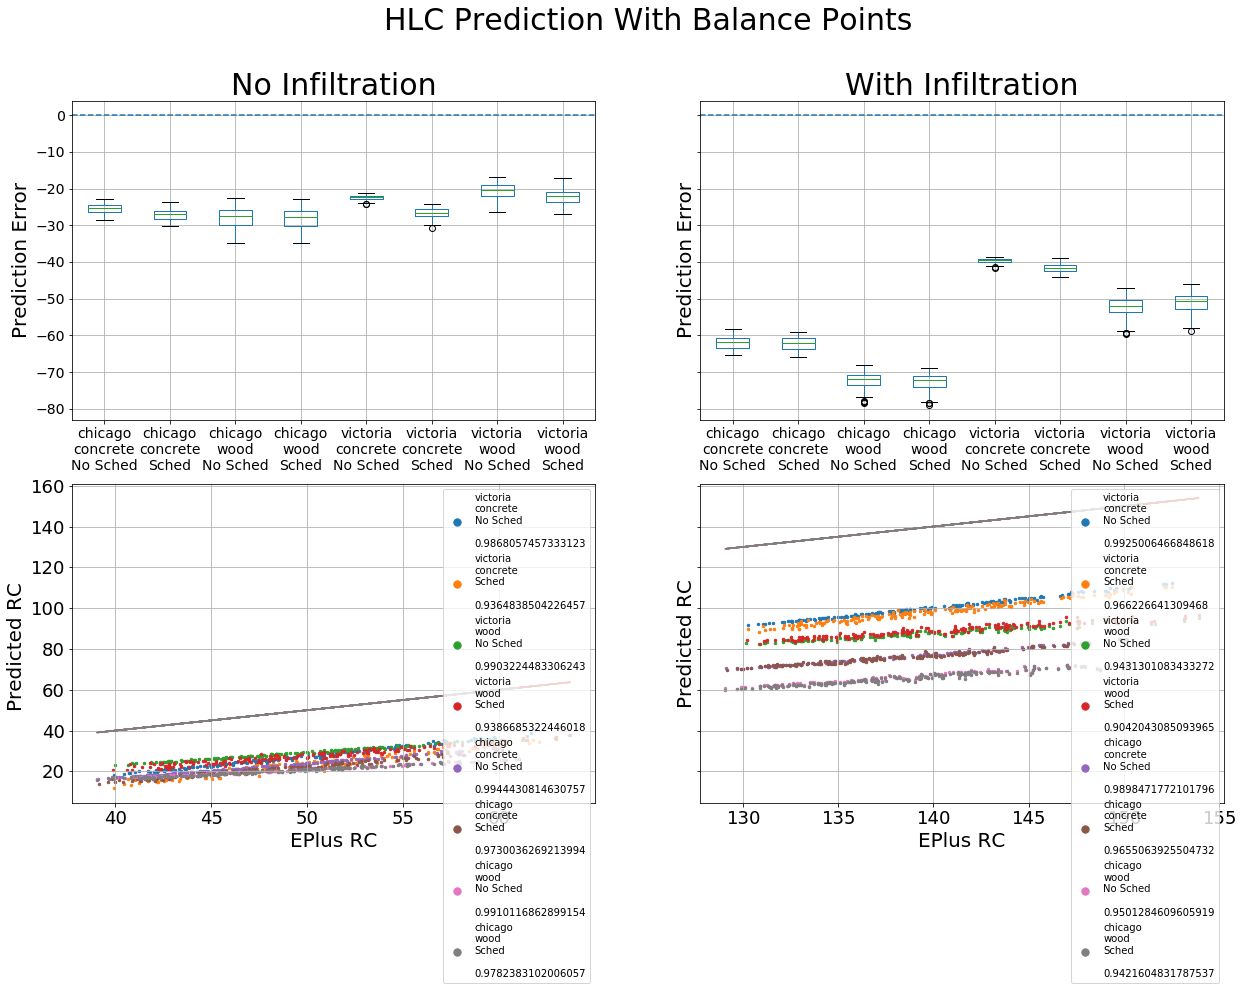

In [38]:
plot_all_cases(bp_results, cases_no_infiltration, cases_w_infiltration, 'HLC', 'HLC Prediction With Balance Points')

# Decay Curves

## With and without schedules

In [11]:
def plot_RC_decay_curves(r1, cases1, cases2, title, save_fig=None):
    fig, axes = plt.subplots(2, 2, figsize=(20,13), sharey='row')

    plot_errors_from_cases(r1, cases1, axes[0,0], 'RC')
    axes[0,0].set_ylabel('Prediction Error', fontsize=20)
    axes[0,0].tick_params(labelsize=14,  axis='both')
    axes[0,0].set_xlabel('', fontsize=20)
    axes[0,0].axhline(0, 0, 1, label='No Error', linestyle='--')

    plot_errors_from_cases(r1, cases2, axes[0,1], 'RC')
    axes[0,1].set_ylabel('Prediction Error', fontsize=20)
    axes[0,1].tick_params(labelsize=14,  axis='both')
    axes[0,1].set_xlabel('', fontsize=20)
    axes[0,1].axhline(0, 0, 1, label='No Error', linestyle='--')

    plot_scatter_cases(r1, cases1, axes[1,0], 'RC')
    axes[1,0].set_title('')
    axes[1,0].grid()
    axes[1,0].tick_params(labelsize=18,  axis='both')
    axes[1,0].set_xlabel('EPlus RC', fontsize=20)
    axes[1,0].set_ylabel('Predicted RC ', fontsize=20)

    plot_scatter_cases(r1, cases2, axes[1,1], 'RC')
    axes[1,1].grid()
    axes[1,1].tick_params(labelsize=18,  axis='both')
    axes[1,1].set_xlabel('EPlus RC', fontsize=20)
    axes[1,1].set_ylabel('Predicted RC', fontsize=20)


    axes[0,0].set_title('No Infiltration', fontsize=30)
    axes[0,1].set_title('With Infiltration', fontsize=30)
    axes[1,0].legend(markerscale=3)
    axes[1,1].legend(markerscale=3)

    plt.suptitle(title, y=1.0, fontsize=30)
    if save_fig: plt.savefig(f'plots/{save_fig}')
    plt.show()
    

/home/gbaasch/envs/dl3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


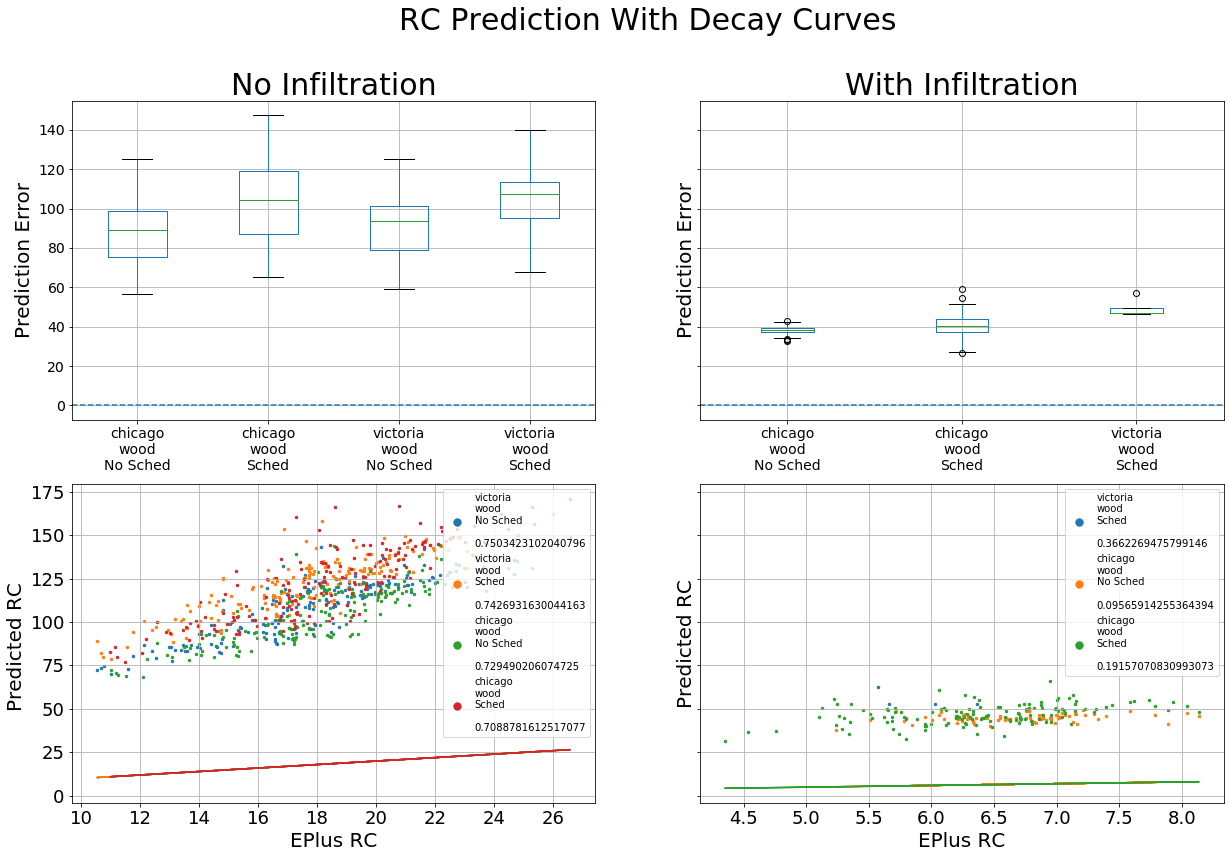

/home/gbaasch/envs/dl3.6/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


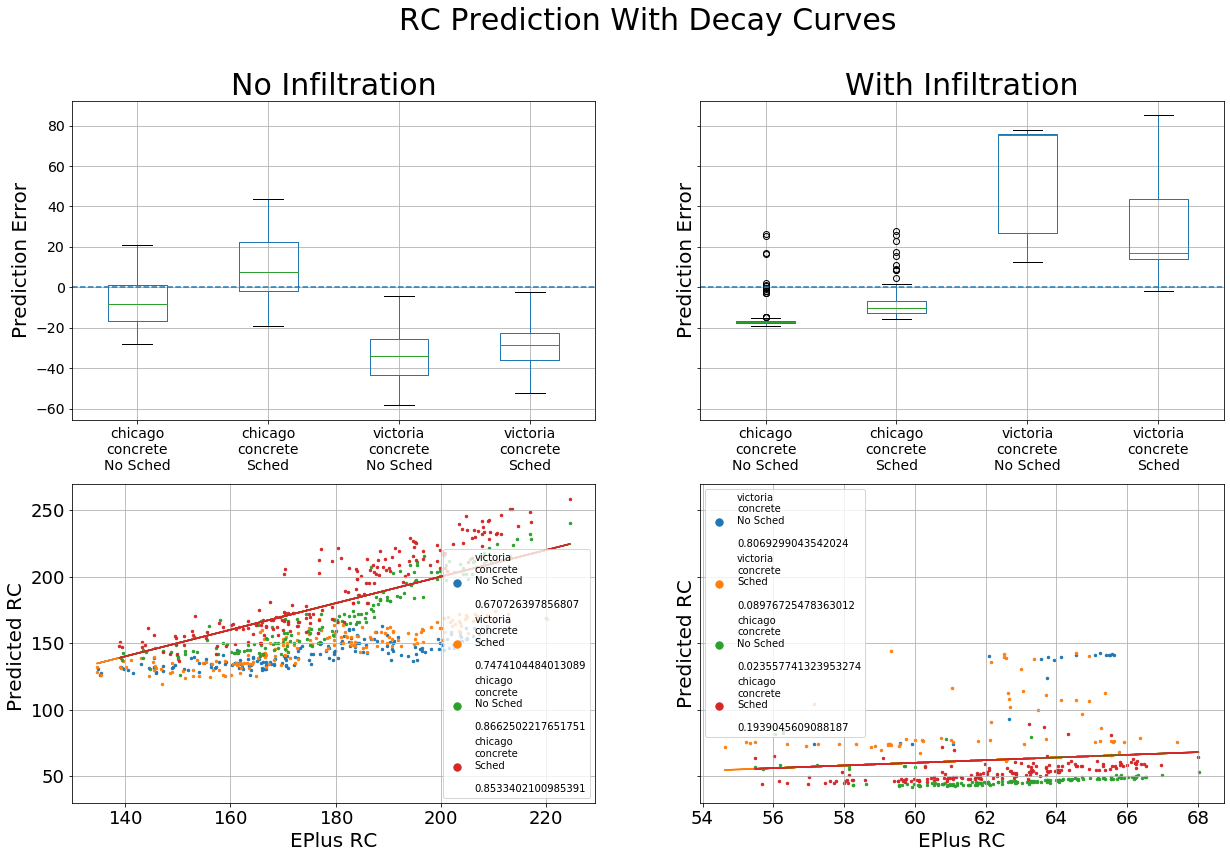

In [49]:
plot_all_cases(dc_results, cases_no_infiltration_wood, cases_w_infiltration_wood, 'RC', 'RC Prediction With Decay Curves')
plot_all_cases(dc_results, cases_no_infiltration_concrete, cases_w_infiltration_concrete, 'RC', 'RC Prediction With Decay Curves')
